In [17]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.linalg
import control

np.random.seed(0)

In [18]:
# common parameters
Time = 10 # total time, seconds
dt = 0.001 # time step
times = np.arange(0, Time, dt)
Nt=len(times)

In [19]:
def run_network(A,x0,B,Kc,x_des,dt,Nt,sigma,network_size=10,signal_dimensions=2,lam=0.1):

    N = network_size #network size

    K = signal_dimensions #signal dimensions

    # kernel
    np.random.seed(0) # for reproducibility
    D=np.random.randn(K,N) # N x K - Weights associated to each neuron
    D=D/np.linalg.norm(D,axis=0) #normalize
    #D = D / np.sqrt(np.diag(D.T@D)) # normalize
    #print(D)
    D = D / 10 # avoid too big discontinuities
    # threshold
    T = np.diag(D.T@D)/2
    #T=np.full(N, 0.0001)

    lam=lam # time constant for the neurons

    # Initialize Voltage, spikes, rate
    V = np.zeros([N,Nt+1])
    s = np.zeros([N,Nt+1])
    r = np.zeros([N,Nt+1])
    
    # List of u's for plotting the external input u
    U = np.zeros([B.shape[1],Nt+1])
    #acc_list = np.zeros([1,Nt+1])
    
    # Set initial conditions
    r[:,0] = np.array(np.linalg.pinv(D)@x0) # pseudo-inverse - "cheaty" way of getting the right firing rate
    V[:,0] = D.T@(x0-D@r[:,0])
    
    #V[:,0] = D.T @ (X[:,0] - (D @ r[:,0]))
    
    #print(V[:,0])

    # Network connections:
    # - fast
    O_f = D[:-2].T @ D[:-2]
    # - slow
    O_s = D[:-2].T @ (lam*np.identity(K-2) + A) @ D[:-2]
    # - rec. control
    O_c = -D[:-2].T @ B @ Kc @ D[:-2]
    # - rec. z
    O_z = D[:-2].T @ B @ Kc @ D[2:]
    
    Dx=np.gradient(x_des,axis=1)/dt
    
    Du=-Kc @ (D[:-2] - D[2:])

    # actual simulation: simple forward Euler
    for t in range(Nt):
        #V[:,t+1] = V[:,t] + (-lam*V[:,t] + ((D.T@((lam*X[:,t])+(X[:,t+1]-X[:,t]))) - O_f@s[:,t]))*dt
        #print(X[:,t])
        #print(X[:,t+1]-X[:,t])
        #print(D.T@((lam*X[:,t])+(X[:,t+1]-X[:,t])))
        #print(D.T@(B*F[t]))
        #print(np.linalg.pinv(B) @ np.linalg.pinv(D.T)@(-(O_c @ r[:,t] - F_c @ x_des[:,t])))
        U[:,t] = Du @ r[:,t]
        
        #print(u)
        #print(B@Kc*((D@r[:,t])-desired_state))
        
        # Calculating the voltages at time t+1
        dVdt = -lam * V[:,t] - O_f @ s[:,t] + O_s @ r[:,t] + (O_c @ r[:,t] + O_z @ r[:,t])
        dVdt = dVdt + (D[2:].T @ ((lam*x_des[:,t])+Dx[:,t])) - (D[2:].T @ D[2:] @ s[:,t])
        V[:,t+1] = V[:,t] + dVdt*dt + np.sqrt(dt)*sigma*np.random.randn(len(dVdt))

        # check if there are neurons whose voltage is above threshold
        above = np.where(V[:,t+1] > T)[0]
    
        # introduce a control to let only one neuron fire at the time
        if len(above):
            s[np.argmax(V[:,t+1]),t+1] = 1/dt

        # update rate
        drdt = s[:,t+1] - lam*r[:,t]
        r[:,t+1] = r[:,t] + drdt*dt
        
        #acc_list[0,t]=D[1]@drdt
    
    return D,r,s,V,T,U

In [20]:
#Parameters
m=20 #mass (in kg)
k=6 #spring constant (in N/m)
c=2 #constant of proportionality (in Ns/m = kg/s)

voltage_noise_sigma = 0.00001

#s = 1; #s=1 for pendulum up. s=-1 for pendulum down

# Setup connectivity for dynamics:
A = np.array([[0,1],
              [(-k/m),(-c/m)]]) # A-matrix, defines dynamics of the DS.

B = np.array([[0],[1/m]]) # B-matrix, defines the influence of the force on the system.
x0 = np.array([5, 0]) # Initial state of the system. x0_3 = u

# Check controllability 
print(control.ctrb(A,np.reshape(B,(2,1))))

# Control-parameters
Q = np.array([[10,0],[0,1]])
R = 0.001
Kc,_,_ = control.lqr(A,B,Q,R)

# Desired states
x0_des = np.full([Nt+1],0) # Desired x0, position.
x1_des = np.full([Nt+1],0) # Desired x1, velocity.

# Change desired state over time
x0_des[int(Nt/5):int(Nt/5)*2] = 5
x0_des[int(Nt/5)*2:int(Nt/5)*3] = 10
x0_des[int(Nt/5)*3:int(Nt/5)*4] = 15
x0_des[int(Nt/5)*4:] = 20

x_des = np.array([x0_des,x1_des]) # Desired states over time.
x0_des = np.concatenate((x0, x_des[:,0]))

D,r,s,_,_,U=run_network(A,x0_des,B,Kc,x_des,dt,Nt,voltage_noise_sigma,50,4,0.1)
X_snn = D @ r # Decode the spike rates into DS states. 

[[ 0.     0.05 ]
 [ 0.05  -0.005]]


In [21]:
#from scipy.integrate import odeint

def simulate_ds(A,x0,B,K,x_des,dt,Nt,U):
    #ds = odeint(A, x0, times)
    
    #def ds()
    
    true_x=np.zeros([len(A),Nt+1])
    #acc_list=np.zeros([1,Nt+1])
    
    true_x[:,0]=x0
    
    for t in range(Nt):
        #print(K*(true_x[:,t]-desired_params))
        dxdt = A@true_x[:,t] + B@U[:,t]
        #acc_list[0,t]=dxdt[1]
        true_x[:,t+1] = true_x[:,t] + dxdt*dt
    return true_x
    

<Figure size 432x864 with 0 Axes>

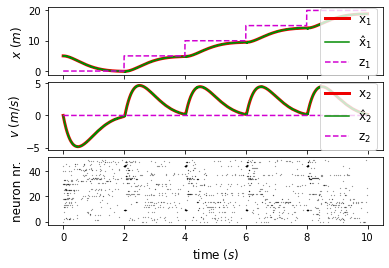

In [22]:
# Plot dynamical variables in seperate plots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(6)
fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,1]})
#fig.set_figheight(4)
#fig.set_figwidth(12)
legend_fontsize=12

#ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), colspan=1)
#ax2 = plt.subplot2grid(shape=(3, 1), loc=(1, 0), colspan=1)
#ax3 = plt.subplot2grid(shape=(3, 1), loc=(0, 1), rowspan=2)

X_true=simulate_ds(A,x0,B,Kc,x_des,dt,Nt,U)

# Run the 'real' dynamical system with previously defined A-matrix and x0:
#_fe = X_hat_fe

# "of position (x$_{1}$ and x̂$_{1}$) and acceleration (x$_{2}$ and x̂$_{2}$)"
legend=[]
axs[0].plot(np.arange(0,Time+dt,dt),X_true[0],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(1)+"}$")
#ax1.plot(np.arange(0,Time+dt,dt),X_hat_fe[0],color='#0000FF')
#legend.append("x̂$_{"+str(1)+"}$_FE")
axs[0].plot(np.arange(0,Time+dt,dt),X_snn[0],color='#008A00')
legend.append("x̂$_{"+str(1)+"}$")
axs[0].plot(np.arange(0,Time+dt,dt),x_des[0],linestyle='dashed',c="#D100D1")
legend.append("z$_{1}$")
axs[0].legend(legend,fontsize=legend_fontsize,loc='right')

legend=[]
axs[1].plot(np.arange(0,Time+dt,dt),X_true[1],color='#EE0000',linewidth=3)
legend.append("x$_{"+str(2)+"}$")
#ax2.plot(np.arange(0,Time+dt,dt),X_hat_fe[1],color='#0000FF')
#legend.append("x̂$_{"+str(2)+"}$_FE")
axs[1].plot(np.arange(0,Time+dt,dt),X_snn[1],color='#008A00')
legend.append("x̂$_{"+str(2)+"}$")
axs[1].plot(np.arange(0,Time+dt,dt),x_des[1],linestyle='dashed',c="#D100D1")
legend.append("z$_{2}$")
axs[1].legend(legend,fontsize=legend_fontsize,loc='right')
    
#axs[0].set(xlabel='time ($ms$)',ylabel='pos. ($m$)')
#axs[0].set(title='SCN Kalman filter (green) estimating and \n controlling dynamical system (red)')
axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[1].set_ylabel('$v$ $(m/s)$',fontsize = 12)
#axs[1].set_xlabel('time ($ms$)',fontsize = 12)

#axs[0,1].axis('off')

# # We use a scatterplot for the spike trains:
axs[2].scatter(np.nonzero(s)[1]/1000,np.nonzero(s)[0],marker=".",s=0.1,color='black')
#print(axs[3].get_position)
#position=(0.13,-0.04,0.77,0.4),
axs[2].set_xlabel('time ($s$)',fontsize = 12)
axs[2].set_ylabel('neuron nr.',fontsize = 12)
#axs[2].set_yticks([0,1,2,3,4,5,6,7,8,9])

plt.savefig('fig6.svg', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.savefig('fig6.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()